In [1]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab import evaluate_agent, multiConstAction, simulator, environment_simulation, plot_selected_sizes, agent_action_plot
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO
from rl4greencrab import LipschitzPPO
from rl4greencrab import plot_agent
import ray

In [2]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0
    # "curriculum": True
}

In [3]:
env = greenCrabMonthEnv(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## greencrab population change over times for each size

In [22]:
agent = multiConstAction(env=env, action=np.array([0, 0, 0]))
constantData = environment_simulation(env, agent)
constantDataDF = pd.DataFrame(constantData)

In [4]:
crab_pop_df = pd.DataFrame(constantDataDF[constantDataDF['rep']==0]['crab_pop'].tolist(), columns=[f'crab_pop_{i}' for i in range(len(constantDataDF['crab_pop'][0]))])
crab_pop_df['t'] = constantDataDF['t']

In [5]:
# Create a multi-select widget for crab size columns
crab_pop_columns = [col for col in crab_pop_df.columns if col.startswith('crab_pop_')]
size_selector = widgets.SelectMultiple(
    options=crab_pop_columns,
    value=[crab_pop_columns[0]],  # Default selection
    description='Sizes',
    disabled=False
)
# Create an interactive plot
interact(lambda selected_sizes: plot_selected_sizes(crab_pop_df, selected_sizes), selected_sizes=size_selector);

interactive(children=(SelectMultiple(description='Sizes', index=(0,), options=('crab_pop_0', 'crab_pop_1', 'cr…

## greencrab size distribution at certain time t

In [12]:
def pop_df_gen(dataDF):
    df = pd.DataFrame(dataDF[dataDF['rep']==0]['crab_pop'].tolist(), 
                      columns=[f'crab_pop_{i}' for i in range(len(dataDF['crab_pop'][0]))])
    df.columns = [i for i in range(len(df.columns))]
    return df

def plot_size_distribution(dataDF, time_step):
    crab_pop_df = pop_df_gen(dataDF)
    plt.figure(figsize=(8, 5))
    plt.bar(crab_pop_df.columns, crab_pop_df.loc[time_step], color='blue', alpha=0.7)
    plt.ylim(0, 20000)
    plt.title(f'Crab Size Distribution at {time_step}')
    plt.xlabel('Crab Size')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

def interact_size_plot(dataDF):
    return interact(
        lambda time_step: plot_size_distribution(dataDF, time_step),
         time_step=dataDF.index
    );

In [9]:
agent = multiConstAction(env=env, action=np.array([0.0, 0, 0.0]))
noInterventionData = environment_simulation(env, agent)
noInterventionDataDF = pd.DataFrame(constantData)
interact_size_plot(noInterventionDataDF)

interactive(children=(Dropdown(description='time_step', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<function __main__.interact_size_plot.<locals>.<lambda>(time_step)>

In [10]:
agent = multiConstAction(env=env, action=np.array([83.87232800633504, 596.3225575635984, 14.882297944474463]))
constantData = environment_simulation(env, agent)
constantDataDF = pd.DataFrame(constantData)
interact_size_plot(constantDataDF)

interactive(children=(Dropdown(description='time_step', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<function __main__.interact_size_plot.<locals>.<lambda>(time_step)>

In [30]:
eval_env = greenCrabMonthEnvNormalized(config)
ppoAgent = PPO.load("../saved_agents/PPO_gcmenorm", device="cpu")
ppoDataDF = pd.DataFrame(environment_simulation(eval_env, ppoAgent))
interact_size_plot(ppoDataDF)

interactive(children=(Dropdown(description='time_step', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<function __main__.interact_size_plot.<locals>.<lambda>(time_step)>

In [13]:
eval_env = greenCrabMonthEnvNormalized(config)
tqcAgent = TQC.load(f"varRatio0.3_new/TQC_gcmenorm", device="cpu")
tqcDataDF = pd.DataFrame(environment_simulation(eval_env, tqcAgent))
interact_size_plot(tqcDataDF)

interactive(children=(Dropdown(description='time_step', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<function __main__.interact_size_plot.<locals>.<lambda>(time_step)>

<Axes: title={'center': 'Actions over Time'}, xlabel='t'>

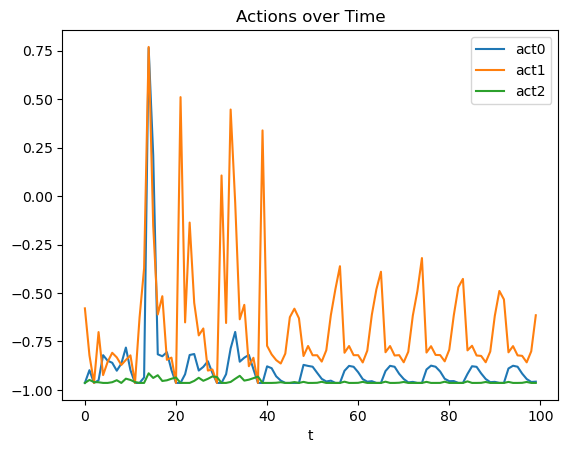

In [15]:
df = tqcDataDF
df[df.rep == 0].iloc[:, :].plot(x='t', y=['act0', 'act1', 'act2'], title="Actions over Time")

Text(0, 0.5, 'size_5')

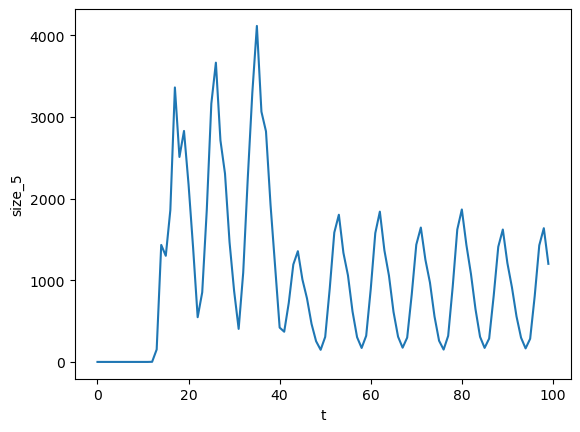

In [24]:
crab_pop_df = pop_df_gen(tqcDataDF)
crab_pop_df.iloc[:, :][8].plot()
plt.xlabel('t')
plt.ylabel('size_5')

In [17]:
act_state_df = df[df.rep == 0].merge(right=crab_pop_df, left_index=True, right_index=True).drop(labels = 'crab_pop', axis=1)

Text(0, 0.5, 'act0')

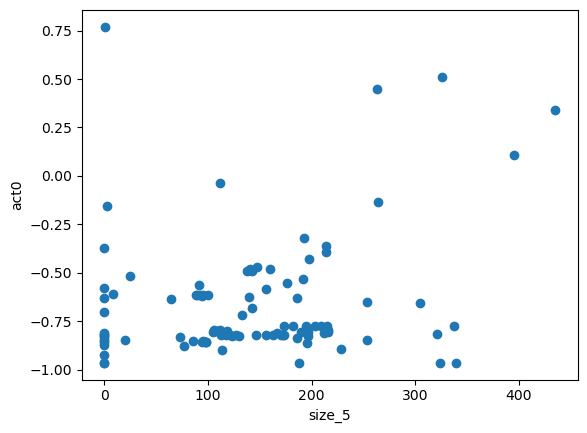

In [27]:
plt.scatter(x=act_state_df[11], y=act_state_df['act1'])
plt.xlabel('size_5')
plt.ylabel('act0')
# act_state_df.plot(x=5, y='act0')

## Overlap Policy Size Distribution

In [16]:
dataDF_list = [noInterventionDataDF, constantDataDF, ppoDataDF]

In [17]:
def plot_size_distr_overlap(dataDF_list, time_step):
    plt.figure(figsize=(8, 5))
    for i, df in enumerate(dataDF_list):
        crab_pop_df = pop_df_gen(df)
        plt.bar(
            crab_pop_df.columns,
            crab_pop_df.loc[time_step],
            alpha=0.5,
            label=f"DataFrame {i+1}"
        )
    plt.legend()
    plt.title(f'Crab Size Distribution at {time_step}')
    plt.xlabel('Crab Size')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

def interact_size_plot(dataDF_list):
    return interact(
        lambda time_step: plot_size_distr_overlap(dataDF_list, time_step),
         time_step=pd.DataFrame(dataDF_list[0]).index
    );

In [18]:
interact_size_plot(dataDF_list)

interactive(children=(Dropdown(description='time_step', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<function __main__.interact_size_plot.<locals>.<lambda>(time_step)>

## Model Reward Distributions

In [28]:
evalEnv =  greenCrabMonthEnvNormalized(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [ ]:
path = "../saved_agents"
td3Agent = TD3.load(f"TD3_gcmenorm", device="cpu")
ppoAgent = PPO.load(f"PPO_gcmenorm", device="cpu")
tqcAgent = TQC.load(f"TQC_gcmenorm", device="cpu")
recurrentPPOAgent = RecurrentPPO.load("RecurrentPPO_gcmenorm_256_1_var0", device="cpu")
lppoAgent = LipschitzPPO.load("LipschitzPPO_gcmenorm_0.001_50", device="cpu")

In [29]:
td3Agent = TD3.load(f"varianceRatio0/TD3_gcmenorm", device="cpu")
ppoAgent = PPO.load(f"varianceRatio0/PPO_gcmenorm", device="cpu")
tqcAgent = TQC.load(f"varRatio0.3_new/TQC_gcmenorm", device="cpu")
recurrentPPOAgent = RecurrentPPO.load("varianceRatio0.3/RecurrentPPO_gcmenorm_256_1_varR0.3", device="cpu")
lppoAgent = LipschitzPPO.load("varRatio0.3_new/LipschitzPPO_gcmenorm_0.1_1", device="cpu")

In [34]:
def evaluateConstAct(x):
    env = greenCrabMonthEnvNormalized(config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    rewards = evaluate_agent(agent=agent, ray_remote=True, gpu=False).evaluate(n_eval_episodes=50, return_episode_rewards=True)
    m_reward = np.mean(rewards)
    return -m_reward, rewards

# normalized constant action
def normalized_action(act, max_act):
    max_action = max_act
    constant_act = np.array(act)
    return constant_act * 2 / max_action - 1 

In [35]:
# normalized constant action
def normalized_action(act, max_act):
    max_action = max_act
    constant_act = np.array(act)
    return constant_act * 2 / max_action - 1 

In [36]:
ray.init()
norm_act = normalized_action([0.0, 0.0, 154.3889141214999], 3000)
m_reward, const_rews = evaluateConstAct(norm_act)
ray.shutdown()

2025-07-17 23:19:13,515	INFO worker.py:1917 -- Started a local Ray instance.


False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'memory': 20640987136.0, 'node:__internal_head__': 1.0, 'object_store_memory': 8846137344.0}


In [37]:
N_EPS = 30
ray.init()
ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
lppo_rew = evaluate_agent(agent=lppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

2025-07-17 23:19:28,315	INFO worker.py:1917 -- Started a local Ray instance.


False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'memory': 20636995994.0, 'node:__internal_head__': 1.0, 'object_store_memory': 8844426854.0}
False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'node:__internal_head__': 1.0, 'memory': 20636995994.0, 'object_store_memory': 8844426854.0}
False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'object_store_memory': 8844426854.0, 'memory': 20636995994.0, 'node:__internal_head__': 1.0}
False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'object_store_memory': 8844426854.0, 'memory': 20636995994.0, 'node:__internal_head__': 1.0}
False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'object_store_memory': 8844426854.0, 'memory': 20636995994.0, 'node:__internal_head__': 1.0}


In [38]:
N_EPS = 200

ppo_rews = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)
td3_rews = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)
tqc_rews = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)
reppo_rews = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)
lppo_rews = evaluate_agent(agent=lppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)

False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'memory': 20636995994.0, 'node:__internal_head__': 1.0, 'object_store_memory': 8844426854.0}
False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'object_store_memory': 8844426854.0, 'node:__internal_head__': 1.0, 'memory': 20636995994.0}
False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'object_store_memory': 8844426854.0, 'node:__internal_head__': 1.0, 'memory': 20636995994.0}
False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'node:__internal_head__': 1.0, 'object_store_memory': 8844426854.0, 'memory': 20636995994.0}
False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'memory': 20636995994.0, 'node:__internal_head__': 1.0, 'object_store_memory': 8844426854.0}


In [39]:
import ray
ray.shutdown()

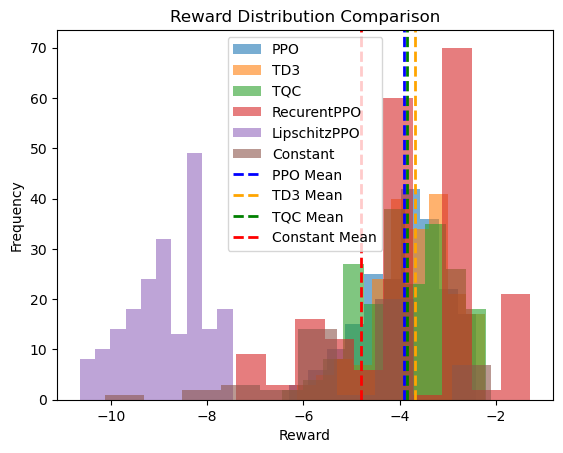

In [40]:
plt.hist(ppo_rews, alpha=0.6, label='PPO')
plt.hist(td3_rews, alpha=0.6, label='TD3')
plt.hist(tqc_rews, alpha=0.6, label='TQC')
plt.hist(reppo_rews , alpha=0.6, label='RecurentPPO')
plt.hist(lppo_rews , alpha=0.6, label='LipschitzPPO')
plt.hist(const_rews, alpha=0.6, label='Constant')

# # Mark means with vertical lines
plt.axvline(np.mean(ppo_rews), color='blue', linestyle='dashed', linewidth=2, label='PPO Mean')
plt.axvline(np.mean(td3_rews), color='orange', linestyle='dashed', linewidth=2, label='TD3 Mean')
plt.axvline(np.mean(tqc_rews), color='green', linestyle='dashed', linewidth=2, label='TQC Mean')
plt.axvline(np.mean(const_rews), color='red', linestyle='dashed', linewidth=2, label='Constant Mean')

plt.legend()
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.title("Reward Distribution Comparison")
plt.show()

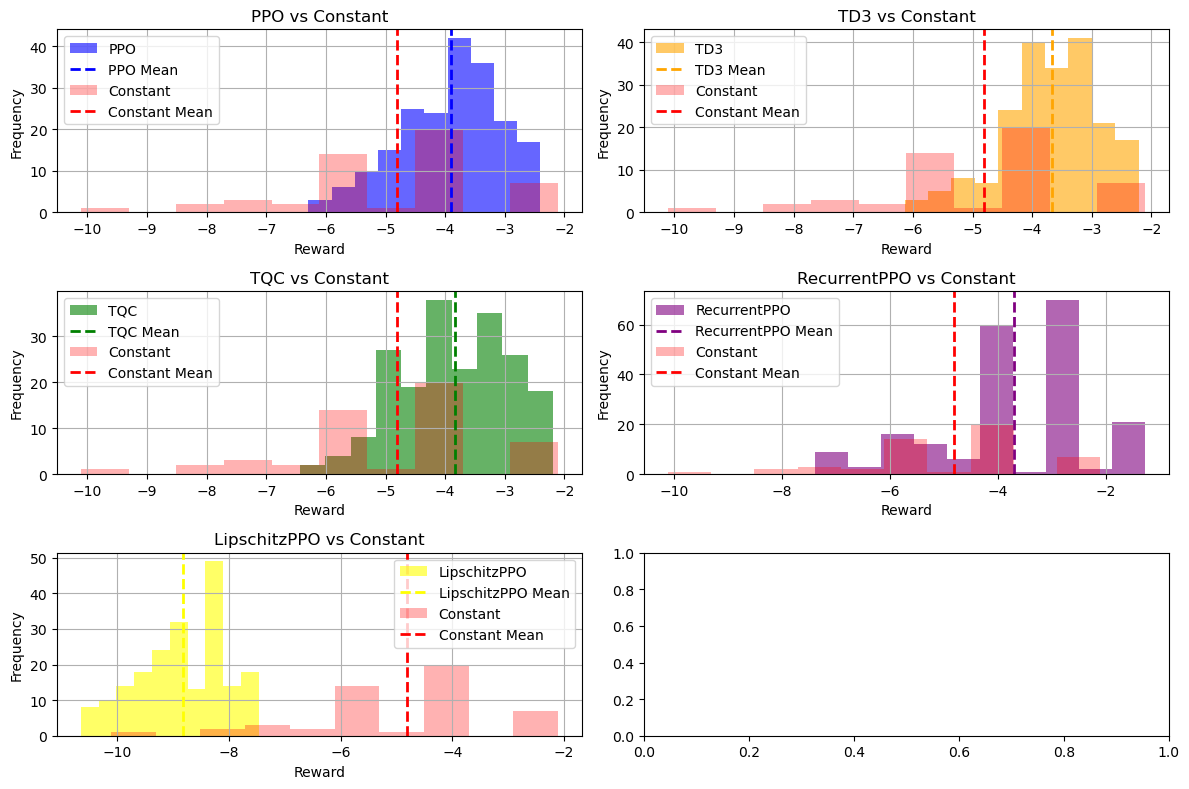

In [41]:
models = {
    'PPO': ppo_rews,
    'TD3': td3_rews,
    'TQC': tqc_rews,
    'RecurrentPPO': reppo_rews,
    'LipschitzPPO': lppo_rews
}
constant_rewards = const_rews

colors = {
    'PPO': 'blue',
    'TD3': 'orange',
    'TQC': 'green',
    'RecurrentPPO': 'purple',
    'LipschitzPPO': 'yellow',
    'Constant': 'red'
}

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, (model_name, rewards) in enumerate(models.items()):
    ax = axes[i]
    # Plot current model
    ax.hist(rewards, alpha=0.6, color=colors[model_name], label=model_name)
    ax.axvline(np.mean(rewards), color=colors[model_name], linestyle='dashed', linewidth=2, label=f'{model_name} Mean')

    # Plot constant model
    ax.hist(constant_rewards, alpha=0.3, color=colors['Constant'], label='Constant')
    ax.axvline(np.mean(constant_rewards), color=colors['Constant'], linestyle='dashed', linewidth=2, label='Constant Mean')

    ax.set_title(f"{model_name} vs Constant")
    ax.set_xlabel("Reward")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [42]:
np.std(ppo_rews), np.std(td3_rews), np.std(tqc_rews), np.std(reppo_rews), np.std(const_rews)

(0.8416968241164418,
 0.8131487920327477,
 0.9248193558479186,
 1.4612546193536518,
 1.7375560377690205)

In [43]:
np.mean(ppo_rews), np.mean(td3_rews), np.mean(tqc_rews), np.mean(reppo_rews), np.mean(lppo_rew), -m_reward

(-3.896557587758272,
 -3.6728092462881854,
 -3.836656606825664,
 -3.7091662992352474,
 -8.790731819455882,
 -4.806115806178462)

## Agent Actions Plot

In [41]:
import os

In [32]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0
    # "curriculum": True
}

In [33]:
evalEnv =  greenCrabMonthEnvNormalized(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [36]:
td3Agent = TD3.load(f"varianceRatio0/TD3_gcmenorm", device="cpu")
ppoAgent = PPO.load(f"varianceRatio0/PPO_gcmenorm", device="cpu")
tqcAgent = TQC.load(f"varRatio0.3_new/TQC_gcmenorm", device="cpu")
recurrentPPOAgent = RecurrentPPO.load("varianceRatio0.3/RecurrentPPO_gcmenorm_256_1_varR0.3", device="cpu")
lppoAgent = LipschitzPPO.load("varRatio0.3_new/LipschitzPPO_gcmenorm_0.1_1", device="cpu")

In [43]:
ppoDataDF = pd.DataFrame(environment_simulation(eval_env, ppoAgent))
DATAPATH = './rl4greencrab/data'
ppoDataDF.to_csv(os.path.join(DATAPATH,f"ppo_env.csv"), index = False)

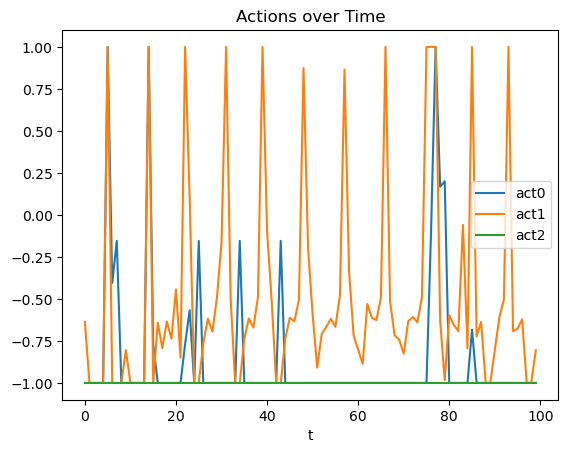

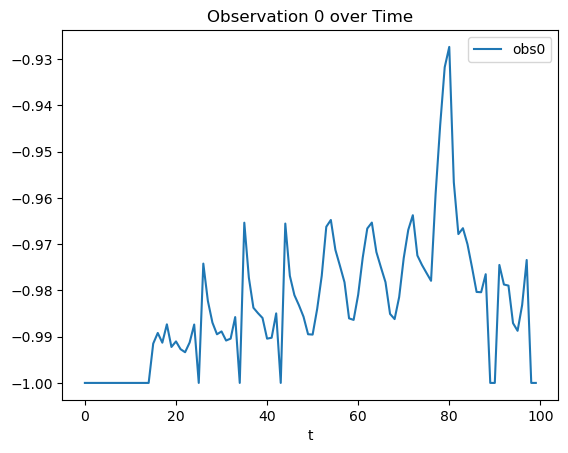

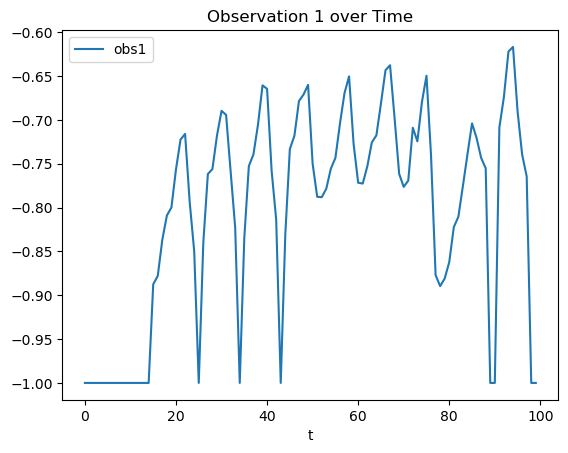

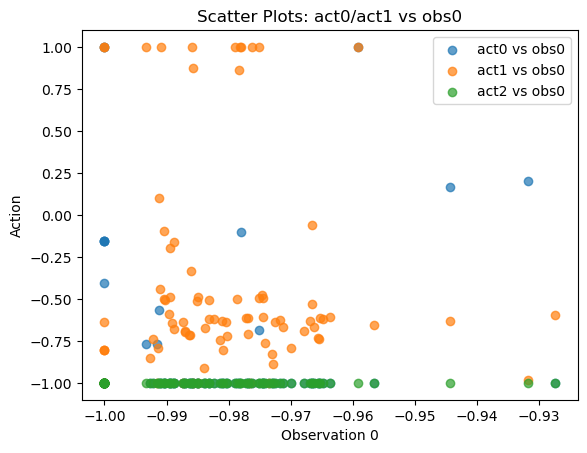

In [17]:
ppoDataDF = agent_action_plot(evalEnv=evalEnv, agent=ppoAgent)

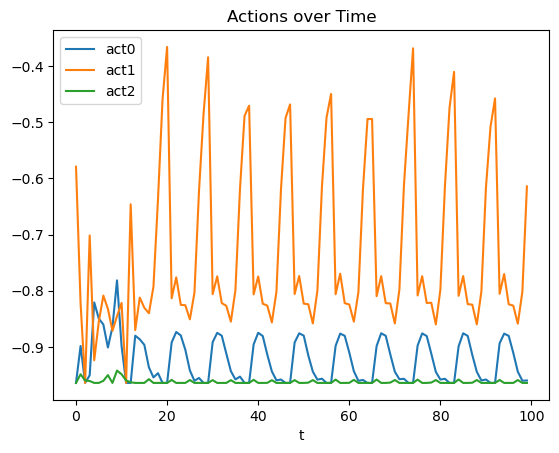

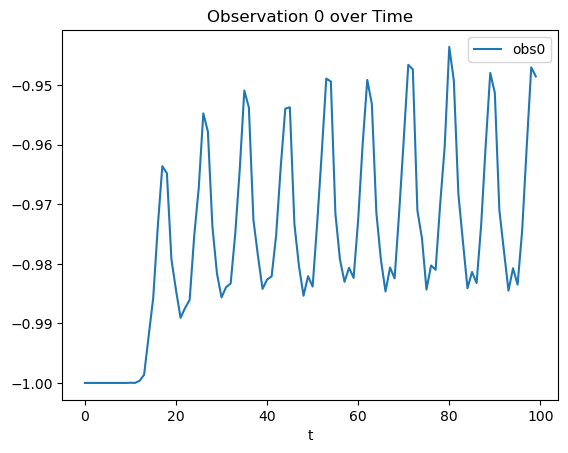

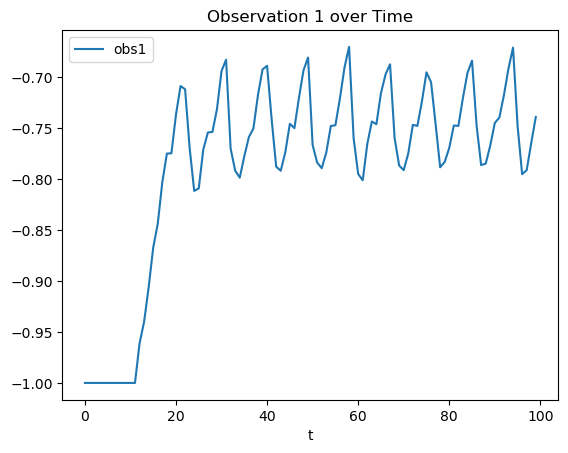

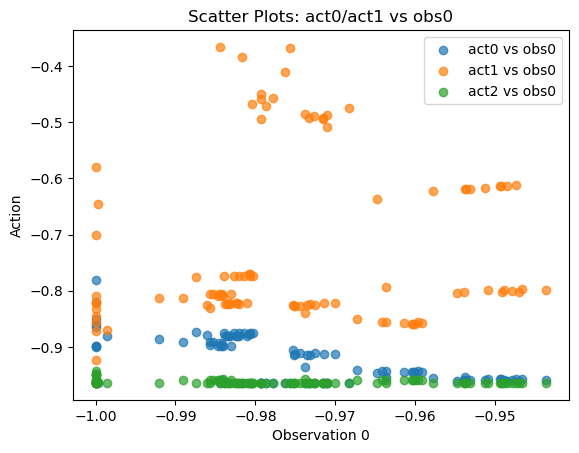

In [105]:
ppoDataDF = agent_action_plot(evalEnv=evalEnv, agent=tqcAgent)

## Rewards plots

In [4]:
ppo_df = pd.read_csv("rl4greencrab/data/ppo_env.csv")
rppo_df = pd.read_csv("rl4greencrab/data/rppo_env.csv")
td3_df = pd.read_csv("rl4greencrab/data/td3_env.csv")
tqc_df = pd.read_csv("rl4greencrab/data/tqc_env.csv")

In [5]:
agent_dict = {
    'td3Agent': td3_df,
    'ppoAgent': ppo_df,
    'tqcAgent': tqc_df,
    'recurrentPPOAgent': rppo_df,
}

In [6]:
from rl4greencrab import generate_policy_rews_df_dfs
rew_df = generate_policy_rews_df_dfs(agent_dict)